In [ ]:
# import zipfile
# my_zip = zipfile.ZipFile('drive-download-20220716T023838Z-001.zip')
# my_zip.extractall()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from ccdproc import CCDData, trim_image, subtract_bias, subtract_dark, flat_correct, Combiner

import astropy.units as u
from astropy.visualization import simple_norm, ImageNormalize, ZScaleInterval

import warnings
warnings.simplefilter("ignore")

import glob
import os
from scipy.signal import medfilt

from photutils import aperture_photometry, DAOStarFinder, CircularAperture, CircularAnnulus
from astropy.stats import sigma_clipped_stats

from astropy.modeling.models import Moffat1D

## Read in data

In [2]:
# data #
# pg1633 (standard star)
pg1633_loc = glob.glob('./data/07*/P[gG]1633*.fits')
pg1633_loc = [loc for loc in pg1633_loc if 'test' not in loc]
pg1633 = []
for x in pg1633_loc:
    image = CCDData.read(x, unit='adu')
    pg1633.append(image)

# pg1648 (standard star)
pg1648_loc = glob.glob('./data/07*/P[gG]1648*.fits')
pg1648 = []
for x in pg1648_loc:
    image = CCDData.read(x, unit='adu')
    pg1648.append(image)
    
# g9348 (standard star)
g9348_loc = glob.glob('./data/07*/[gG]9348*.fits')
g9348 = []
for x in g9348_loc:
    image = CCDData.read(x, unit='adu')
    g9348.append(image)


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

In [3]:
# biases #
bias = []
bias_07 = glob.glob('./data/07072022/bias*.fits')
bias_08 = glob.glob('./data/07082022/bias*.fits')

for x in bias_07:
    image = CCDData.read(x, unit='adu')
    bias.append(image)

for x in bias_08:
    image = CCDData.read(x, unit='adu')
    bias.append(image)
    
# sky flats
skyflats = []
skyflats_loc = glob.glob('./data/07*/sky*.fits')
skyflats_loc = [loc for loc in skyflats_loc if 'test' not in loc]

for x in skyflats_loc:
    image = CCDData.read(x, unit='adu')
    skyflats.append(image)
    
# dome flats
domeflats = []
domeflats_loc = glob.glob('./data/07*/*dome*.fits')
domeflats_loc = [loc for loc in domeflats_loc if 'test' not in loc]

for x in domeflats_loc:
    image = CCDData.read(x, unit='adu')
    domeflats.append(image)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

## _Removing Instrumental Signature+Illumination Correction_

### Removing Bias

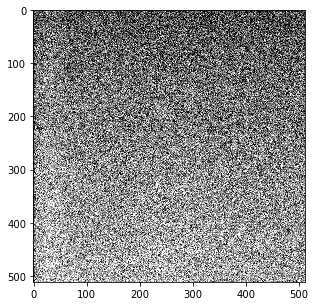

In [5]:
biases = Combiner(bias)
master_bias = biases.median_combine()
master_bias.header = bias[0].header
master_bias.header['Combined'] = 'Combined with biases from 07 and 08'

plt.figure(figsize=(5,5))
plt.imshow(master_bias, vmin=np.percentile(master_bias, 5),vmax=np.percentile(master_bias, 95), 
          cmap='gray', interpolation='nearest');

In [7]:
# data bias subtraction
pg1633_bias = []
for file in pg1633:
    bias = subtract_bias(file, master_bias, add_keyword=True)
    pg1633_bias.append(bias)

pg1648_bias = []
for file in pg1648:
    bias = subtract_bias(file, master_bias, add_keyword=True)
    pg1648_bias.append(bias)
    
g9348_bias = []
for file in g9348:
    bias = subtract_bias(file, master_bias, add_keyword=True)
    g9348_bias.append(bias)

In [8]:
# sky flats bias subtraction
skyflats_bias = []
for file in skyflats:
    bias = subtract_bias(file, master_bias, add_keyword=True)
    skyflats_bias.append(bias)

In [9]:
# dome flats bias subtraction
domeflats_bias = []
for file in domeflats:
    bias = subtract_bias(file, master_bias, add_keyword=True)
    domeflats_bias.append(bias)

### Master Flat

In [10]:
def filter_fn(images):
    B = []
    V = []
    r = []
    for file in images:
        x = file.header['filter']
        if x == 'B':
            B.append(file)
        elif x == 'V':
            V.append(file)
        elif x == 'r':
            r.append(file)
    return B, V, r

def masterflat_fn(flat, flattype, filt):
    flats = Combiner(flat)
    master_flat = flats.median_combine()
    master_flat.header = flat[0].header
    master_flat.header['Combined'] = f'Combined {flattype} flats'
    master_flat.header['filter'] = f'{filt}'
    return master_flat
    
def flatcorrect_fn(images, flattype):
    i = []
    for file in images:
        x = file.header['filter']
        if x == 'B':
            flatcorrected = flat_correct(file, flattype[0])
            i.append(flatcorrected)
        elif x == 'V':
            flatcorrected = flat_correct(file, flattype[1])
            i.append(flatcorrected)
        elif x == 'r':
            flatcorrected = flat_correct(file, flattype[2])
            i.append(flatcorrected)
        else:
            continue
    return i

In [11]:
# dome master flats
domeflats_B, domeflats_V, domeflats_r = filter_fn(domeflats_bias)
domemasterflat_B = masterflat_fn(domeflats_B, 'dome', 'B')
domemasterflat_V = masterflat_fn(domeflats_V, 'dome', 'V')
domemasterflat_r = masterflat_fn(domeflats_r, 'dome', 'r')
domemasterflats = [domemasterflat_B, domemasterflat_V, domemasterflat_r]

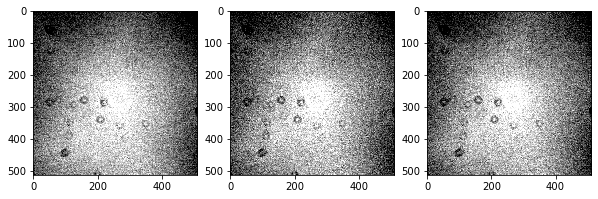

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(domemasterflat_B, vmin=np.percentile(domemasterflat_B, 5), 
           vmax=np.percentile(domemasterflat_B, 95), cmap='gray', interpolation='nearest');
plt.subplot(1,3,2)
plt.imshow(domemasterflat_V, vmin=np.percentile(domemasterflat_V, 5), 
           vmax=np.percentile(domemasterflat_V, 95), cmap='gray', interpolation='nearest');
plt.subplot(1,3,3)
plt.imshow(domemasterflat_r, vmin=np.percentile(domemasterflat_r, 5), 
           vmax=np.percentile(domemasterflat_r, 95), cmap='gray', interpolation='nearest');

In [13]:
pg1633_dome = flatcorrect_fn(pg1633_bias, domemasterflats)
pg1648_dome = flatcorrect_fn(pg1648_bias, domemasterflats)
g9348_dome = flatcorrect_fn(g9348_bias, domemasterflats)

In [14]:
# sky master flats
skyflats_B, skyflats_V, skyflats_r = filter_fn(skyflats)

In [15]:
# need to combine skyflats from same days
def date_fn(images):
    _08 = []
    _09 = []
    _11 = []
    for file in images:
        date = file.header['date-obs']
        if '-08T' in date:
            _08.append(file)
        elif '-09T' in date:
            _09.append(file)
        elif '-11T' in date:
            _11.append(file)
        else:
            continue
    return _08, _09, _11

In [16]:
# skyflats_B, skyflats_V, skyflats_r = filter_fn(skyflats)
skyflats_B_07, skyflats_B_08, _ = date_fn(skyflats_B)
skyflats_V_07, skyflats_V_08, _ = date_fn(skyflats_V)
skyflats_r_07, skyflats_r_08, _ = date_fn(skyflats_r)

skymasterflat_B_07 = masterflat_fn(skyflats_B_07, 'sky', 'B')
skymasterflat_B_08 = masterflat_fn(skyflats_B_08, 'sky', 'B')

skymasterflat_V_07 = masterflat_fn(skyflats_V_07, 'sky', 'V')
skymasterflat_V_08 = masterflat_fn(skyflats_V_08, 'sky', 'V')

skymasterflat_r_07 = masterflat_fn(skyflats_r_07, 'sky', 'r')
skymasterflat_r_08 = masterflat_fn(skyflats_r_08, 'sky', 'r')

skymasterflats_07 = [skymasterflat_B_07, skymasterflat_V_07, skymasterflat_r_07]
skymasterflats_08 = [skymasterflat_B_08, skymasterflat_V_08, skymasterflat_r_08]

In [17]:
for x in skyflats_B_07:
    print(x.header['date-obs'])

2022-07-08T04:25:58
2022-07-08T04:28:17
2022-07-08T04:28:25
2022-07-08T04:28:33
2022-07-08T04:28:41
2022-07-08T04:28:48
2022-07-08T04:28:56
2022-07-08T04:29:04


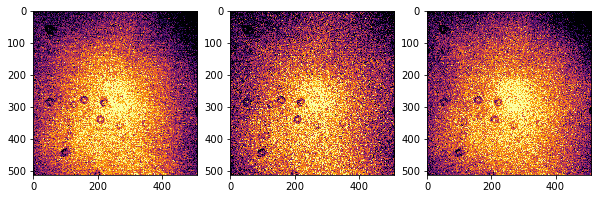

In [18]:
# 07
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(skymasterflat_B_07, vmin=np.percentile(skymasterflat_B_07, 5), 
           vmax=np.percentile(skymasterflat_B_07, 95), cmap='inferno', interpolation='nearest');
plt.subplot(1,3,2)
plt.imshow(skymasterflat_V_07, vmin=np.percentile(skymasterflat_V_07, 5), 
           vmax=np.percentile(skymasterflat_V_07, 95), cmap='inferno', interpolation='nearest');
plt.subplot(1,3,3)
plt.imshow(skymasterflat_r_07, vmin=np.percentile(skymasterflat_r_07, 5), 
           vmax=np.percentile(skymasterflat_r_07, 95), cmap='inferno', interpolation='nearest');

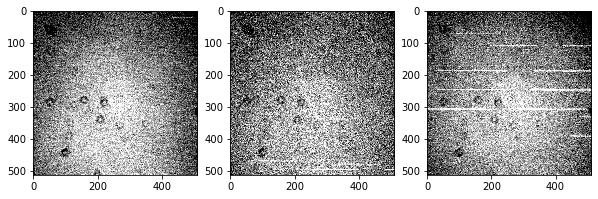

In [19]:
# 08
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(skymasterflat_B_08, vmin=np.percentile(skymasterflat_B_08, 5), 
           vmax=np.percentile(skymasterflat_B_08, 95), cmap='gray', interpolation='nearest');
plt.subplot(1,3,2)
plt.imshow(skymasterflat_V_08, vmin=np.percentile(skymasterflat_V_08, 5), 
           vmax=np.percentile(skymasterflat_V_08, 95), cmap='gray', interpolation='nearest');
plt.subplot(1,3,3)
plt.imshow(skymasterflat_r_08, vmin=np.percentile(skymasterflat_r_08, 5), 
           vmax=np.percentile(skymasterflat_r_08, 95), cmap='gray', interpolation='nearest');

In [20]:
pg1633_07, pg1633_08, _ = date_fn(pg1633_bias)
pg1633_sky_07 = flatcorrect_fn(pg1633_07, skymasterflats_07)
pg1633_sky_08 = flatcorrect_fn(pg1633_08, skymasterflats_08)
pg1633_sky = pg1633_sky_07.append(pg1633_sky_08)

pg1648_07, pg1648_08, _ = date_fn(pg1648_bias)
pg1648_sky_07 = flatcorrect_fn(pg1648_07, skymasterflats_07)
pg1648_sky_08 = flatcorrect_fn(pg1648_08, skymasterflats_08)
pg1648_sky = pg1648_sky_07.append(pg1648_sky_08)

g9348_07, g9348_08, _ = date_fn(g9348_bias)
g9348_sky_07 = flatcorrect_fn(g9348_07, skymasterflats_07)
g9348_sky_08 = flatcorrect_fn(g9348_08, skymasterflats_08)
g9348_sky = g9348_sky_08

### Illumination Correction

In [21]:
illum_B_07 = skymasterflats_07[0].data/domemasterflats[0].data
illum_B_08 = skymasterflats_08[0].data/domemasterflats[0].data

illum_V_07 = skymasterflats_07[1].data/domemasterflats[1].data
illum_V_08 = skymasterflats_08[1].data/domemasterflats[1].data

illum_r_07 = skymasterflats_07[2].data/domemasterflats[2].data
illum_r_08 = skymasterflats_08[2].data/domemasterflats[2].data


illum_07 = [illum_B_07, illum_V_07, illum_r_07]
illum_08 = [illum_B_08, illum_V_08, illum_r_08]

# def illumcorrect_fn(images, illumtype):
#     i = []
#     for file in images:
#         x = file.header['filter']
#         if x == 'B':
#             illumcorrected = file, illum
#             i.append(illumcorrected)
#         elif x == 'V':
#             flatcorrected = flat_correct(file, flattype[1])
#             i.append(flatcorrected)
#         elif x == 'r':
#             flatcorrected = flat_correct(file, flattype[2])
#             i.append(flatcorrected)
#         else:
#             continue
#     return i

In [22]:
def mean_fn(star):
    i = []
    for image in star:
        meaned = image.data/np.mean(image.data)
        i.append(meaned)
    return i

# for x in pg1633_loc:
#     image = CCDData.read(x, unit='adu')
#     pg1633.append(image)

# def masterflat_fn(flat, flattype, filt):
#     flats = Combiner(flat)
#     master_flat = flats.median_combine()
#     master_flat.header = flat[0].header
#     master_flat.header['Combined'] = f'Combined {flattype} flats'
#     master_flat.header['filter'] = f'{filt}'
#     return master_flat


In [23]:
# pg1633_dome_07, pg1633_dome_08, _ = date_fn(mean_fn(pg1633_dome))
# pg1648_dome_07, pg1648_dome_08, _ = date_fn(mean_fn(pg1648_dome))
# g9348_dome_07, g9348_dome_08, _ = date_fn(mean_fn(g9348_dome))
# lilsal_07, lilsal_08, _ = date_fn(mean_fn(lilsal_dome))

illum_mean_07 = mean_fn(illum_07)
illum_mean_08 = mean_fn(illum_08)

In [24]:
# gaussian fn?
def illumnorm_fn(illum):
    i = []
    for x in illum:
        y = medfilt(x)
        i.append(y)
    return i

illum_norm_07 = illumnorm_fn(illum_mean_07)
illum_norm_08 = illumnorm_fn(illum_mean_08)

# plt.subplot(1, 2, 1)
# plt.imshow(illum_norm_07[0], vmin=np.percentile(illum_norm_07[0], 5), 
#            vmax=np.percentile(illum_norm_07[0], 95), cmap='gray', interpolation='nearest');
# plt.subplot(1, 2, 2)
# plt.imshow(illum_07[0], vmin=np.percentile(illum_07[0], 5), 
#            vmax=np.percentile(illum_07[0], 95), cmap='gray', interpolation='nearest');

In [25]:
def illumcr_fn(star, illum):
    i = []
    for image in star:
        x = file.header['filter']
        if x == 'B':
            cr = image.data/illum[0]
            y = CCDData(cr, unit='adu')
            y.header = image.header
            i.append(y)
        if x == 'V':
            cr = image.data/illum[1]
            y = CCDData(cr, unit='adu')
            y.header = image.header
            i.append(y)
        if x == 'r':
            cr = image.data/illum[2]
            y = CCDData(cr, unit='adu')
            y.header = image.header
            i.append(y)
        else:
            continue
    return i

# def flatcorrect_fn(images, flattype):
#     i = []
#     for file in images:
#         x = file.header['filter']
#         if x == 'B':
#             flatcorrected = flat_correct(file, flattype[0])
#             i.append(flatcorrected)
#         elif x == 'V':
#             flatcorrected = flat_correct(file, flattype[1])
#             i.append(flatcorrected)
#         elif x == 'r':
#             flatcorrected = flat_correct(file, flattype[2])
#             i.append(flatcorrected)
#         else:
#             continue
#     return i

pg1633_07, pg1633_08, _ = date_fn(pg1633_bias)
pg1633_illum_07 = illumcr_fn(pg1633_07, illum_norm_07)
pg1633_illum_08 = illumcr_fn(pg1633_08, illum_norm_08)
# pg1633_sky = pg1633_sky_07.append(pg1633_sky_08)

pg1648_07, pg1648_08, _ = date_fn(pg1648_bias)
pg1648_illum_07 = illumcr_fn(pg1648_07, illum_norm_07)
pg1648_illum_08 = illumcr_fn(pg1648_08, illum_norm_08)
# pg1648_sky = pg1648_sky_07.append(pg1648_sky_08)

g9348_07, g9348_08, _ = date_fn(g9348_bias)
g9348_illum_07 = illumcr_fn(g9348_07, illum_norm_07)
g9348_illum_08 = illumcr_fn(g9348_08, illum_norm_08)
# g9348_sky = g9348_sky_08


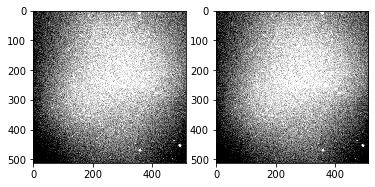

In [26]:
plt.subplot(1, 2, 1)
plt.imshow(pg1633_07[0], vmin=np.percentile(pg1633_07[0], 5), 
           vmax=np.percentile(pg1633_07[0], 95), cmap='gray', interpolation='nearest');
plt.subplot(1, 2, 2)
plt.imshow(pg1633_illum_07[0], vmin=np.percentile(pg1633_illum_07[0], 5), 
           vmax=np.percentile(pg1633_illum_07[0], 95), cmap='gray', interpolation='nearest');

In [27]:
print(np.median(pg1633_07[0]), np.median(pg1633_illum_07[0]))

3946.0 3945.4562760503186


3218.8659271233046 3226.750151718763 143.86384741225848


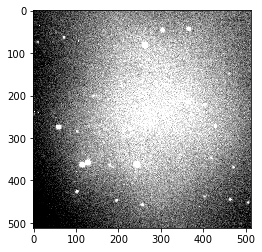

In [28]:
# using G9348_V_60
sn_test = g9348_sky[4]
mean, median, std = sigma_clipped_stats(sn_test, sigma=3.0)
znorm = ImageNormalize(sn_test, interval=ZScaleInterval())
print(mean, median, std)
plt.imshow(sn_test, vmin=np.percentile(sn_test, 5), 
           vmax=np.percentile(sn_test, 95), cmap='gray', interpolation='nearest');

In [29]:
annulus_r_in = 15
annulus_r_out = 30

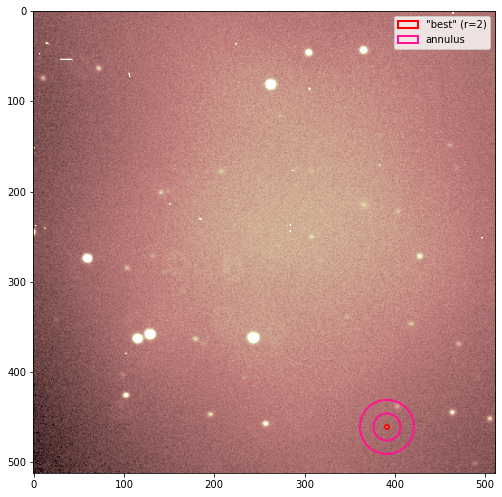

In [31]:
daofind = DAOStarFinder(fwhm=2, threshold=10*std, exclude_border=True)
sources = daofind(sn_test.data)

positions = []
for x, y in zip(sources['xcentroid'], sources['ycentroid']):
    points = [x, y]
    positions.append(points)
positions = positions[7]
    
aperture_best = CircularAperture(positions, r=2)

annulus = CircularAnnulus(positions, r_in=annulus_r_in, r_out=annulus_r_out)

# Plotting apertures is easy with photutils aperture objects: just add .plot
plt.figure(figsize = (11,8.5))
plt.imshow(sn_test,norm=znorm,cmap='pink')
aperture_best.plot(color='red', linewidth=2, label='"best" (r=2)')
annulus.plot(color='deeppink', linewidth=2, label='annulus')
plt.legend();